In [130]:
import pandas as pd
import sqlite3
import zipfile
import numpy as np
from  pandasql import sqldf
from matplotlib import pyplot as plt


# Master Data Filtering and Cleaning

After identifying the data sets needed by all members of our team, we first cleaned the `tn.movie_budgets.csv.gz` by converting it to a Pandas DataFrame and stripping all punctuation from the columns related to finance. All items in these columns were then converted to . A new column was created in the DataFrame called "ROI" in which the return on investment was calculated using the following equation:

##### worldwide_gross - budget)/(worldwide_gross)

Yet another column was then added named "start_year" in order to help with joining the DataFrame in later steps. Finally, all rows where worldwide gross was zero were eliminated from the data.

In [131]:
tn_movie = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_movie

#Remove all $ and commas for domestic gross, worldwide gross, and production budget

tn_movie["production_budget"]=tn_movie["production_budget"].map(lambda x: int(x.replace(',', '').replace('$', '')))
tn_movie["domestic_gross"]=tn_movie["domestic_gross"].map(lambda x: int(x.replace(',', '').replace('$', '')))
tn_movie["worldwide_gross"]=tn_movie["worldwide_gross"].map(lambda x: int(x.replace(',', '').replace('$', '')))


#Add ROI column - defined as (worldwide_gross - budget)/(worldwide_gross)
tn_movie["ROI"]= (tn_movie["worldwide_gross"]- tn_movie["production_budget"])/    \
         tn_movie["production_budget"]

#Add start year as int column

tn_movie["start_year"] = tn_movie["release_date"].map(lambda x: int(x[-4:]))

#Eliminate any worldwide gross columns that = 0

tn_movie = tn_movie [tn_movie .worldwide_gross != 0]

# tn_movie

Next a connection was established to the unzipped `im.db` file and a curser was created. The master data set required us to select all columns from the `movie_basics` table which were put into a new DataFrame. This DataFrame was then joined with the `tn_movie` DataFrame above and joined into a new DataFrame named `imdb_basics`.

In [132]:

conn = sqlite3.connect('zippedData/im.db')
cur= conn.cursor()
# cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""").fetchall()

In [133]:
q1 = """SELECT * FROM movie_basics ;"""
dfzip=pd.read_sql(q1, conn)
imdb_basics = pd.merge(left= dfzip ,right = tn_movie, left_on=["start_year","primary_title"], \
                       right_on=["start_year","movie"], \
                          how = 'inner')
# imdb_basics

# Goal 2 - Writer and Director Profitablity


## Return on Investment for Directors

The first step was joining our imdb_basics table to our directors and persons tables and then convert the newly SQL table to a Pandas DataFrame.

In [134]:
movie_to_director = """
SELECT mb.primary_title AS title, 
    mb.start_year,
    p.primary_name as director_name,
    p.death_year as dead

    
FROM movie_basics AS mb 
JOIN directors AS d 
    ON d.movie_id = mb.movie_id 
JOIN persons as p
    ON p.person_id= d.person_id


ORDER BY primary_title ASC;"""

In [135]:
directors = pd.read_sql(movie_to_director, conn)
directors = directors.drop_duplicates() 

Next, we merged our DataFrame that connected movies to directors to the `imdb_basics` DataFrame we created as part of our master data set. We perfomed an inner join to keep only the films with the same title that also shared  start years. We joined on two columns in order to avoid false joins where different films have the same title.

In [136]:
d_info_all = pd.merge(left= imdb_basics, right = directors, how = "inner", left_on=["start_year","movie"],\
                  right_on=["start_year","title"])


In [137]:
print("Budget 25th Percentile: ",np.percentile(d_info_all["production_budget"],25))
print("Budget 75th Percentile: ",np.percentile(d_info_all["production_budget"],75))


Budget 25th Percentile:  10000000.0
Budget 75th Percentile:  65000000.0


This data left a lot to be desired, as we had deceased directors, incredibly small budgeted films, and extemely high budgeted films in our data. This was cleaned, eliminating directors that had passed at the time of this data's collection. The data was also constrained to a minimum budget of 10 million dollars and a maximum of 65 million dollars, based on the budget data's 25th and 75th percentiles, respectively. Given the client, this range is ideal as 10 million dollars is an extremely conservative film budget and not much for them to spend. 65 million dollars seems to be a good maximum, as they are establishing a new studio and do should not spend all potential capital on one or two films. These constraints will find a director who is comfortable working in this budget range and returning a profit.

In [138]:

#Filter out the deceased and lower mid budget (btw $10 mil and 65 $mil)
dia = d_info_all[(d_info_all["dead"].isna()) & (d_info_all["production_budget"]>= 10000000) \
                 & (d_info_all["production_budget"]<= 65000000)]

#Give us the column we want
dia2 = dia[["movie", "ROI", "director_name"]]
dia2.sort_values(by = ["ROI"], ascending = False)

,movie,ROI,director_name
1198,The Fault in Our Stars,24.597236,Josh Boone
533,Halloween,24.490067,David Gordon Green
111,Black Swan,24.482055,Darren Aronofsky
1436,La La Land,20.317558,Damien Chazelle
1597,Annabelle: Creation,19.358991,David F. Sandberg
...,...,...,...
214,Accidental Love,-0.994791,David O. Russell
818,Freaks of Nature,-0.997850,Robbie Pickering
0,Foodfight!,-0.998362,Lawrence Kasanoff
1360,10 Days in a Madhouse,-0.998782,Timothy Hines


After additional filtering, we now have a DataFrame of all films, their ROI, and their director. As every director has directed films of various budgets, the mean of all ROI was calculated for each director. The results were then listed in decending order and finally graphed on a bar graph.

In [139]:
d_roi = dia2.groupby(['director_name']).mean().sort_values(by=["ROI"], ascending = False)
d_roi


,ROI
director_name,
Josh Boone,24.597236
Darren Aronofsky,24.482055
David F. Sandberg,19.358991
John Krasinski,18.677782
Adam Robitel,15.788559
...,...
David Hayter,-0.994725
Robbie Pickering,-0.997850
Lawrence Kasanoff,-0.998362


''

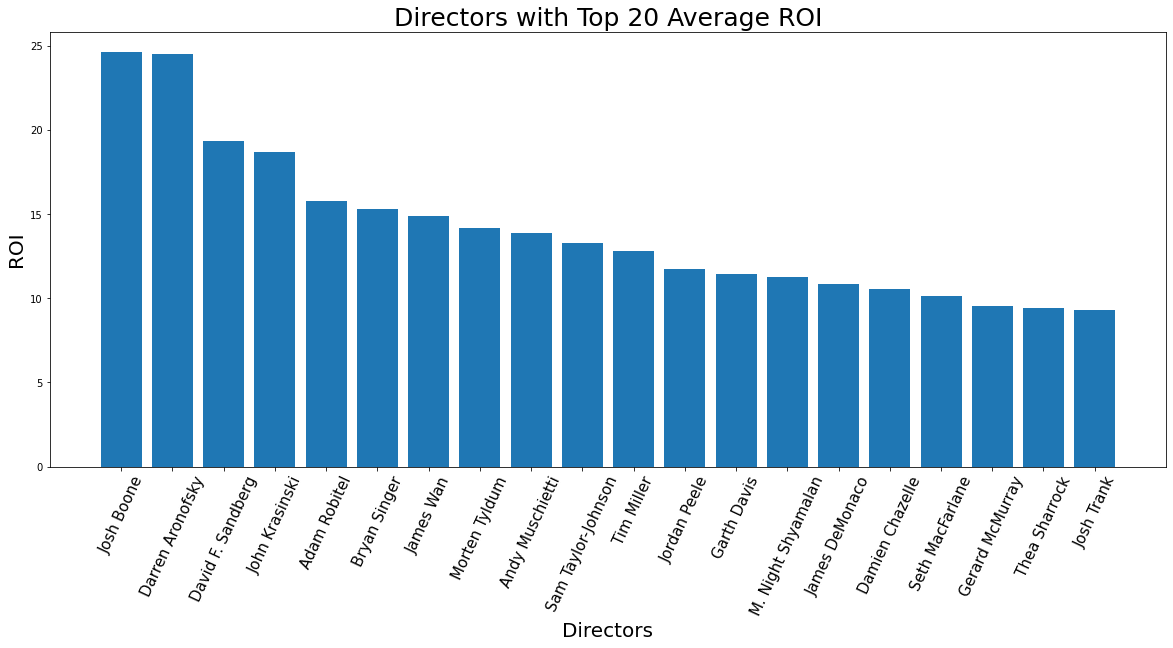

In [166]:
fig, ax = plt.subplots(figsize = (20,8))

d_roi2 = d_roi.head(20)

ax.bar(
    x=d_roi2.index,
    height=d_roi2["ROI"]
)
plt.xticks(fontsize = 15, rotation = 65)
ax.set_title("Directors with Top 20 Average ROI", fontsize = 25)
ax.set_xlabel("Directors", fontsize =20)
ax.set_ylabel("ROI", fontsize =20)
# plt.savefig('director_roi.png')
;

As can be seen, our data filtering has yeilded the client with a list of  directors with the top 20 ROI. It includes notable directors such as Darren Aronofsky, James Wan, Jordan Peele and M. Night Shyamalan. This graph of the top 20 will be presented to the client as well as the full list upon request. However, this is still 20 choices, which may be overwhelming to the client. This will be further filtered after we create a list of writers with the top ROI.

## Return on Investment for Writers

The first step was joining our imdb_basics table to our writers and persons tables and then convert the newly SQL table to a Pandas DataFrame.

In [141]:
movie_to_writer = """
SELECT mb.primary_title AS title,
    mb.start_year,
    w.person_id, 
    p.primary_name as writer_name,
    p.death_year as dead
    
FROM movie_basics AS mb 
JOIN writers AS w 
    ON mb.movie_id = w.movie_id 
JOIN persons as p
    ON p.person_id= w.person_id


ORDER BY primary_title ASC;"""


In [142]:
writers = pd.read_sql(movie_to_writer, conn)
writers = writers.drop_duplicates() 

Next, we merged our DataFrame that connected movies to writers to the `imdb_basics` DataFrame we created as part of our master data set. An inner join was performed in order to keep only the films with the same title that also shared  start years. We joined on two columns in order to avoid false joins where different films have the same title.

In [143]:
w_info_all = pd.merge(left= imdb_basics, right = writers, how = "inner", left_on=["movie", "start_year"],\
                  right_on=["title", "start_year"])


This was cleaned accoring to the guidelines we followed in directors. All deceased writers were eliminated from the new DataFrame and the budget was yet again constrained to the 25th and 75th percentiles (10 million dollars to 65 million dollars).

In [144]:


#Filter out the dead and lower - mid budget (between $10 mil and $65 mil)
wia = w_info_all[(w_info_all["dead"].isna()) & (w_info_all["production_budget"]>= 10000000) \
                 & (w_info_all["production_budget"]<= 65000000)]
#Give us the column we want
wia2 = wia[["movie", "ROI", "writer_name"]]
wia2.sort_values(by = ["ROI"], ascending = False)

,movie,ROI,writer_name
2783,The Fault in Our Stars,24.597236,Scott Neustadter
2782,The Fault in Our Stars,24.597236,Michael H. Weber
2781,The Fault in Our Stars,24.597236,John Green
1315,Halloween,24.490067,John Carpenter
1316,Halloween,24.490067,David Gordon Green
...,...,...,...
2,Foodfight!,-0.998362,Lawrence Kasanoff
0,Foodfight!,-0.998362,Sean Catherine Derek
3129,10 Days in a Madhouse,-0.998782,Timothy Hines
2730,Broken Horses,-0.999769,Abhijat Joshi


After additional filtering, we now have a DataFrame of all films, their ROI, and their writers. The mean of each writers ROIs were calculated. The results were then listed in decending order and graphed on a bar graph.

In [145]:
w_roi = wia2.groupby(['writer_name']).mean().sort_values(by=["ROI"], ascending = False)
w_roi 

,ROI
writer_name,
Jeff Fradley,24.490067
David Gordon Green,24.490067
Andres Heinz,24.482055
Mark Heyman,24.482055
Damien Chazelle,20.317558
...,...
Joshua Wexler,-0.998362
Brent V. Friedman,-0.998362
Timothy Hines,-0.998782


''

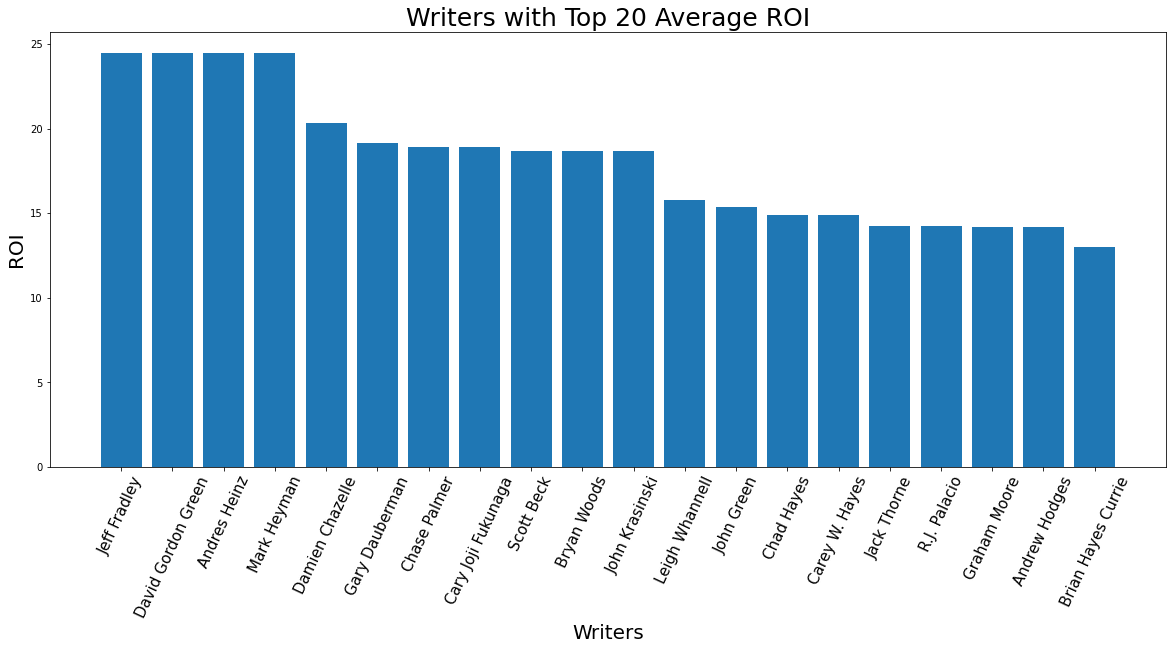

In [164]:
fig, ax = plt.subplots(figsize = (20,8))

w_roi2 = w_roi.head(20)  #

ax.bar(
    x=w_roi2.index,
    height=w_roi2["ROI"]
)
plt.xticks(fontsize = 15, rotation = 65)
ax.set_title("Writers with Top 20 Average ROI", fontsize = 25)
ax.set_xlabel("Writers", fontsize =20)
ax.set_ylabel("ROI", fontsize =20)
# plt.savefig('writer_roi.png')
;

As can be seen, our data filtering has yeilded the clinet with a list of writers with the top 20 ROIs. Notable individuals on the list include: David Gordon Green, Cary Fukunaga, and John Krasinski. This graph of the top 20 will be presented to the client as well as the full list upon request. We still have many writers to choose from and we need to match them to a director. 


However, it would be much simpler to get a writer who is also a director, to save the trouble of having to mach the two roles. It also introduces potential cost savings in streamlining production, as you would only need pay the director slightly more to do the work of two people, rather than paying two seperate people full salaries.

# Who can both direct and write and still deliver the highest return on investment?


First we will join our director and writer DataFrames.

In [147]:
d_w_combo = pd.merge(left= dia, right = wia, how = "inner", left_on=["movie", "start_year"],\
                  right_on=["title", "start_year"])

Then we will filter our DataFrame to only rows where the writer and director are the same and return a list of mean ROI by director in descending order.

In [148]:
d_w_combo_fil = d_w_combo[d_w_combo["director_name"]==d_w_combo["writer_name"]]
dwc =  d_w_combo_fil[["movie_x", "ROI_x", "writer_name", "director_name"]]
dirwr = dwc.groupby(['writer_name']).mean().sort_values(by=["ROI_x"], ascending = False)
dirwr.head()

,ROI_x
writer_name,
David Gordon Green,24.490067
Damien Chazelle,20.317558
John Krasinski,18.677782
Jordan Peele,11.710515
M. Night Shyamalan,11.265175


This list can then be turned into a bar graph, showing the director/writers that yield the highest return on investment for mid-tier budgeted films. 

''

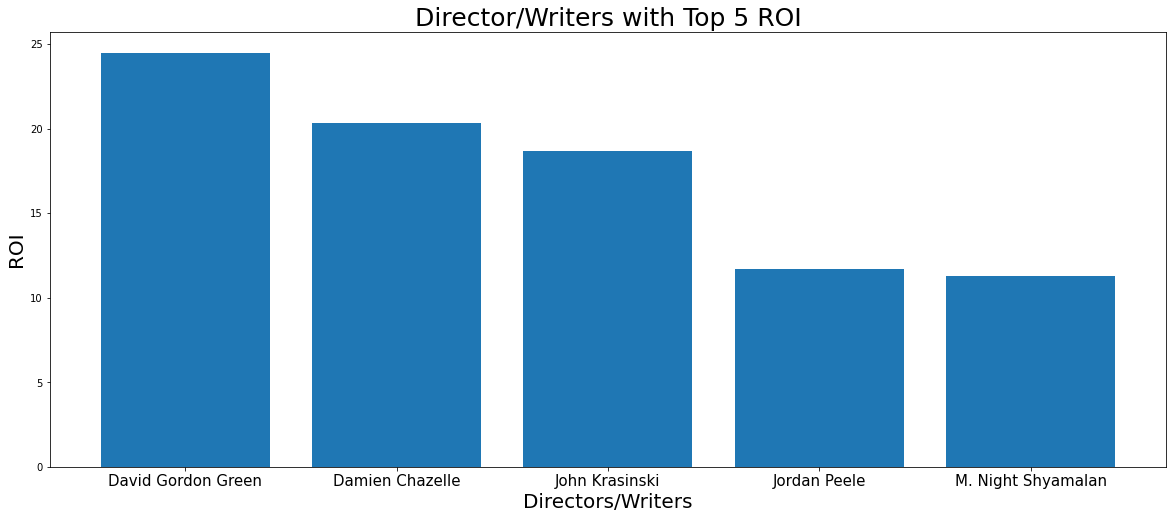

In [162]:
fig, ax = plt.subplots(figsize = (20,8))

top_5 = dirwr.head()

ax.bar(
    x=top_5.index,
    height=top_5["ROI_x"]
)
ax.set(title = "Director/Writers with Top 5 ROI", xlabel = "Directors/Writers", ylabel = "ROI Returned")
plt.xticks(fontsize = 15, rotation = 0)
ax.set_title("Director/Writers with Top 5 ROI", fontsize = 25)
ax.set_xlabel("Directors/Writers", fontsize =20)
ax.set_ylabel("ROI", fontsize =20)
# plt.savefig('director_writer_roi.png')
;

### From this data, we would recomend that our client hires the  writer/director with the highest average return on investment, David Gordon Green.

# Appendix: 

#### Is critical reception correlated to ROI? Worldwide Gross? Domestic Gross?

In [155]:
mb_to_ratings = """
SELECT mb.primary_title AS title,
    mb.start_year,
    rt.averagerating,
    rt.numvotes
    
FROM movie_basics AS mb 
JOIN movie_ratings AS rt
    ON mb.movie_id = rt.movie_id 

ORDER BY rt.numvotes DESC;"""

movie_ratings = pd.read_sql(mb_to_ratings, conn)

In [156]:
crit_rate = movie_ratings[(movie_ratings["numvotes"]>= 50000)]
#Preventing low rating numbers from affecting results
    
    
crit_all = pd.merge(left= imdb_basics, right = crit_rate, how = "inner", left_on=["movie", "start_year"],\
                  right_on=["title", "start_year"])

crit_use_unsort = crit_all[["title","production_budget","domestic_gross", "worldwide_gross", "ROI", \
                            "averagerating", "numvotes" ]]

crit_use_unsort2=crit_use_unsort[(crit_use_unsort["production_budget"] >= 10000000) \
                                 & (crit_use_unsort["production_budget"] <= 65000000)] 
#Filtering data further by only looking at movies with production budgets of $10 million or more

crit_use = crit_use_unsort2.sort_values(by = ["averagerating"], ascending = False)
crit_use

,title,production_budget,domestic_gross,worldwide_gross,ROI,averagerating,numvotes
818,Green Book,23000000,85080171,322034439,13.001497,8.3,204972
785,Baahubali 2: The Conclusion,30000000,18985794,263502914,7.783430,8.3,65656
693,Room,13000000,14677674,36262783,1.789445,8.2,316791
215,Warrior,25000000,13657115,24215385,-0.031385,8.2,403755
790,"Three Billboards Outside Ebbing, Missouri",12000000,54513740,160191915,12.349326,8.2,344047
...,...,...,...,...,...,...,...
354,LOL,11000000,0,10431506,-0.051681,4.4,51424
338,Skyline,10000000,21416355,68264973,5.826497,4.4,83710
236,Movie 43,10000000,8840453,31164747,2.116475,4.3,92980
599,Fifty Shades of Grey,40000000,166167230,570998101,13.274953,4.1,279126


''

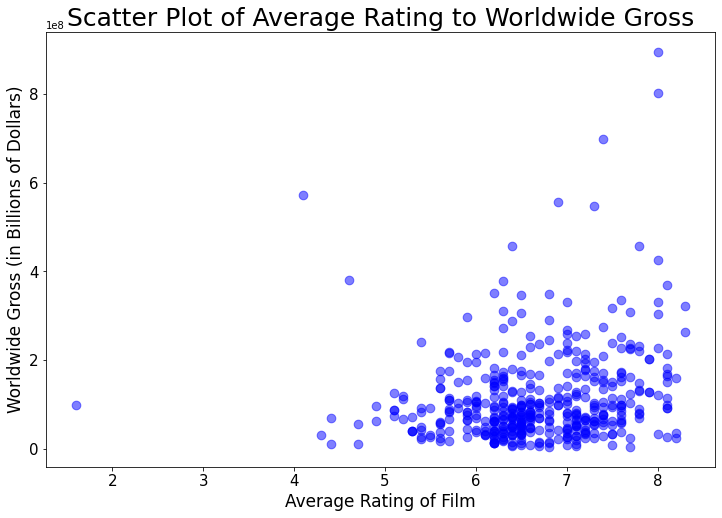

In [159]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))

rate = crit_use["averagerating"]
wwgross = crit_use["worldwide_gross"]
dgross = crit_use["domestic_gross"]
roi = crit_use["ROI"]


ax.scatter(x = rate, y =wwgross,  s = 75, color = "blue", alpha = .5)



plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_title("Scatter Plot of Average Rating to Worldwide Gross", fontsize = 25)
ax.set_xlabel("Average Rating of Film", fontsize =17)
ax.set_ylabel("Worldwide Gross (in Billions of Dollars)", fontsize =17)
# plt.savefig('rate_avg_to_gross')
;



In [158]:
correlation_roi = rate.corr(roi)
correlation_ww = rate.corr(wwgross)
correlation_d = rate.corr(dgross)

print("Person Correslation between average critical rating and ROI is: ", correlation_roi)
print("Person Correslation between average critical rating and worldwide gross is: ", correlation_ww)
print("Person Correslation between average critical rating and domestic gross is: ", correlation_d)


Person Correslation between average critical rating and ROI is:  0.2635491590834754
Person Correslation between average critical rating and worldwide gross is:  0.20064166316125998
Person Correslation between average critical rating and domestic gross is:  0.21592316957128463


#### So there is a positve correlation between critcal rating and ROI/Worldwide gross/domestic gross but its not a high/significant result.

# Future
### Look into the ROI for actors/actresses to help narrow down casting
### Narrow down writers by region/language to get even more relevant results
### Figure out if runtime affects profitability 
### Track if a directors ROI can be predicted through modeling (ex. If certain director is given budget X, the ROI will most likely be in Y range
### Create a program that you can enter one or more of several variables, and will output ideal director/writer/time of release/etc. based on input

### Look into the ROI for actors/actresses to help narrow down casting


### Gather/find new information reguarding the marketing budget and its relationship to total gross and ROI